In [1]:
!pip install pandas==2.1.1
!pip install scorecardpy==0.1.9.7

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.4/345.4 kB 31.0 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 1.5.3
    Uninstalling pandas-1.5.3:
      Successfully uninstalled pandas-1.5.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==1.5.3, but you have pandas 2.1.1 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.1/58.1 kB 1.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scorecardpy: filename=scorecardpy-0.1.9.7-py3-none-any.whl size=60634 sha256=983f3e8a91e6c45900d2e576775be4c590af791fa41e1db1f9262cbcfe38dfb4
  Stored in directory: /root/.cache/pip/wheels/49/49/e9/7b845548eed3624ce37effdd13e9cb95a99272d692eb9e9e23
Successfully built scorecar

In [2]:
import warnings

import pandas as pd, numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn import linear_model, metrics

import scorecardpy as sc
import pprint

In [3]:
# sample code
# data file is the same as Session 7 lab data
full_data = pd.read_csv('final_data.csv')

with pd.option_context('display.max_rows', 6):
    display(full_data)

# use a copy of hmeq_data for credit risk model
full_data_copy = full_data.copy()
full_data_copy["DAYS_CREDIT_INVERSE"] = -full_data_copy["DAYS_CREDIT"]

# check for missing values
full_data_copy.isnull().sum()

/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:49: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


,SK_ID_CURR,TARGET,ORGANIZATION_TYPE,DAYS_CREDIT,REGION_POPULATION_RELATIVE,Days_Employed_Positive,LTV_Ratio,Age_at_Loan_Application,Credit_Length,Annuity_Over_Credit,Credit_Utilization_Ratio,AMT_CREDIT
0,100003,0,School,-1400.750000,0.003541,1188,1.145199,170.252055,3.837671,0.027598,0.000000,1293502.5
1,100041,0,Self-employed,-1292.538462,0.008575,1275,1.000000,157.630137,3.541201,0.098910,0.000000,450000.0
2,100088,0,School,-1408.200000,0.022800,4066,1.000000,177.654795,3.858082,0.050000,0.284085,135000.0
...,...,...,...,...,...,...,...,...,...,...,...,...
8006,456239,0,Business Entity Type 3,-1529.909091,0.025164,7438,1.198000,181.641096,4.191532,0.029399,0.669159,808650.0
8007,456240,0,Self-employed,-1438.500000,0.004960,2178,1.000000,171.841096,3.941096,0.050000,0.602304,337500.0
8008,456255,0,Business Entity Type 3,-1089.454545,0.046220,1262,1.000000,170.501370,2.984807,0.072767,0.555116,675000.0


SK_ID_CURR                      0
TARGET                          0
ORGANIZATION_TYPE               0
DAYS_CREDIT                   833
REGION_POPULATION_RELATIVE      0
Days_Employed_Positive          0
LTV_Ratio                       7
Age_at_Loan_Application         0
Credit_Length                 833
Annuity_Over_Credit             3
Credit_Utilization_Ratio      868
AMT_CREDIT                      0
DAYS_CREDIT_INVERSE           833
dtype: int64

In [4]:
# full_data_copy.drop(columns=["SK_ID_CURR", "DAYS_CREDIT", "Credit_Length", "Annuity_Over_Credit"], inplace=True)
#full_data_copy.drop(columns=["SK_ID_CURR","DAYS_CREDIT", "REGION_POPULATION_RELATIVE", "Annuity_Over_Credit"], inplace=True)
full_data_copy.drop(columns=["SK_ID_CURR","DAYS_CREDIT"], inplace=True)

In [6]:
from sklearn.preprocessing import LabelEncoder

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Encode the 'School' column
full_data_copy['Organisation_Type_Encoded'] = label_encoder.fit_transform(full_data_copy['ORGANIZATION_TYPE'])

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


In [7]:
full_data_copy.drop(columns=["ORGANIZATION_TYPE"], inplace=True)

In [5]:
# Define the groups
groups = {
    'Education Related': ['School', 'Kindergarten', 'University'],
    'Government and Public Services': ['Government', 'Security Ministries', 'Police', 'Military', 'Emergency', 'Postal', 'Realtor'],
    'Business Entities and Trade': ['Business Entity Type 1', 'Business Entity Type 2', 'Business Entity Type 3', 'Trade: type 1', 'Trade: type 2', 'Trade: type 3', 'Trade: type 4', 'Trade: type 5', 'Trade: type 6', 'Trade: type 7'],
    'Transportation': ['Transport: type 1', 'Transport: type 2', 'Transport: type 3', 'Transport: type 4'],
    'Industry and Commerce': ['Industry: type 1', 'Industry: type 2', 'Industry: type 3', 'Industry: type 4', 'Industry: type 5', 'Industry: type 6', 'Industry: type 7', 'Industry: type 8', 'Industry: type 9', 'Industry: type 10', 'Industry: type 11', 'Industry: type 12', 'Advertising', 'Cleaning', 'Construction', 'Housing', 'Legal Services', 'Services'],
    'Financial and Insurance': ['Bank', 'Insurance'],
    'Utilities and Communication': ['Electricity', 'Telecom'],
    'Healthcare': ['Medicine'],
    'Agriculture and Farming': ['Agriculture'],
    'Hospitality and Leisure': ['Culture', 'Hotel', 'Restaurant'],
    'Other': ['Other', 'Mobile', 'Religion']
}

# groups = {
#     1: ['School', 'Kindergarten', 'University'],
#     2: ['Government', 'Security Ministries', 'Police', 'Military', 'Emergency', 'Postal', 'Realtor'],
#     3: ['Business Entity Type 1', 'Business Entity Type 2', 'Business Entity Type 3', 'Trade: type 1', 'Trade: type 2', 'Trade: type 3', 'Trade: type 4', 'Trade: type 5', 'Trade: type 6', 'Trade: type 7'],
#     4: ['Transport: type 1', 'Transport: type 2', 'Transport: type 3', 'Transport: type 4'],
#     5: ['Industry: type 1', 'Industry: type 2', 'Industry: type 3', 'Industry: type 4', 'Industry: type 5', 'Industry: type 6', 'Industry: type 7', 'Industry: type 8', 'Industry: type 9', 'Industry: type 10', 'Industry: type 11', 'Industry: type 12', 'Advertising', 'Cleaning', 'Construction', 'Housing', 'Legal Services', 'Services'],
#     6: ['Bank', 'Insurance'],
#     7: ['Electricity', 'Telecom'],
#     8: ['Medicine'],
#     9: ['Agriculture'],
#     10: ['Culture', 'Hotel', 'Restaurant'],
#     11: ['Other', 'Mobile', 'Religion']
# }

# Function to encode organization type
def encode_organization_type(org_type):
    for group, categories in groups.items():
        if org_type in categories:
            return group
    return 'Other'

# Apply encoding to 'ORGANIZATION_TYPE' column
full_data_copy['ORGANIZATION_TYPE_encoded'] = full_data_copy['ORGANIZATION_TYPE'].apply(encode_organization_type)


In [8]:
y = 'TARGET'

train, test = sc.split_df(full_data_copy, y, ratio = .8).values()
print(train.shape)
print(test.shape)

(6408, 11)
(1601, 11)


/usr/local/lib/python3.10/dist-packages/scorecardpy/condition_fun.py:92: UserWarning: There are infinite or NaN values in 1 columns, which are replaced with -999.
 (ColumnNames: Credit_Utilization_Ratio)
  warnings.warn(


In [9]:
#y = 'TARGET'
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    bins = sc.woebin(train, y = y)
print(type(bins))

# make it easy to read the bins
for variable, bindetails in bins.items():
    print(f'{variable=}')
    display(bindetails)
    print('-' * 100)

[INFO] creating woe binning ...
Binning on 6408 rows and 11 columns in 00:00:13
<class 'dict'>
variable='AMT_CREDIT'


/usr/local/lib/python3.10/dist-packages/google/colab/_dataframe_summarizer.py:75: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif pd.api.types.is_categorical_dtype(column):


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,AMT_CREDIT,"[-inf,400000.0)",1410,0.220037,1349,61,0.043262,-0.143893,0.004272,0.097733,400000.0,False
1,AMT_CREDIT,"[400000.0,800000.0)",2283,0.356273,2129,154,0.067455,0.325897,0.043894,0.097733,800000.0,False
2,AMT_CREDIT,"[800000.0,1250000.0)",1466,0.228777,1411,55,0.037517,-0.292369,0.017172,0.097733,1250000.0,False
3,AMT_CREDIT,"[1250000.0,1450000.0)",500,0.078027,473,27,0.054000,0.089093,0.000645,0.097733,1450000.0,False
4,AMT_CREDIT,"[1450000.0,inf)",749,0.116885,728,21,0.028037,-0.593427,0.031750,0.097733,inf,False


----------------------------------------------------------------------------------------------------
variable='REGION_POPULATION_RELATIVE'


/usr/local/lib/python3.10/dist-packages/google/colab/_dataframe_summarizer.py:75: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif pd.api.types.is_categorical_dtype(column):


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,REGION_POPULATION_RELATIVE,"[-inf,0.008)",1156,0.180400,1101,55,0.047578,-0.044289,0.000347,0.058877,0.008,False
1,REGION_POPULATION_RELATIVE,"[0.008,0.032)",3921,0.611891,3698,223,0.056873,0.143976,0.013539,0.058877,0.032,False
2,REGION_POPULATION_RELATIVE,"[0.032,inf)",1331,0.207709,1291,40,0.030053,-0.521941,0.044992,0.058877,inf,False


----------------------------------------------------------------------------------------------------
variable='DAYS_CREDIT_INVERSE'


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,DAYS_CREDIT_INVERSE,missing,662,0.103308,624,38,0.057402,0.153788,0.002620,0.127313,missing,True
1,DAYS_CREDIT_INVERSE,"[-inf,350.0)",361,0.056336,326,35,0.096953,0.720803,0.040749,0.127313,350.0,False
2,DAYS_CREDIT_INVERSE,"[350.0,900.0)",1696,0.264669,1616,80,0.047170,-0.053331,0.000735,0.127313,900.0,False
3,DAYS_CREDIT_INVERSE,"[900.0,1350.0)",1841,0.287297,1732,109,0.059207,0.186668,0.010895,0.127313,1350.0,False
4,DAYS_CREDIT_INVERSE,"[1350.0,1450.0)",336,0.052434,330,6,0.017857,-1.054981,0.037261,0.127313,1450.0,False
5,DAYS_CREDIT_INVERSE,"[1450.0,inf)",1512,0.235955,1462,50,0.033069,-0.423186,0.035054,0.127313,inf,False


----------------------------------------------------------------------------------------------------
variable='LTV_Ratio'


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,LTV_Ratio,missing,5,0.000780,5,0,0.000000,1.234727,0.002471,0.066499,missing,True
1,LTV_Ratio,"[-inf,1.06)",3215,0.501717,3074,141,0.043857,-0.132449,0.008294,0.066499,1.06,False
2,LTV_Ratio,"[1.06,1.09)",347,0.054151,337,10,0.028818,-0.567972,0.013619,0.066499,1.09,False
3,LTV_Ratio,"[1.09,1.1600000000000001)",1582,0.246879,1499,83,0.052465,0.055813,0.000789,0.066499,1.1600000000000001,False
4,LTV_Ratio,"[1.1600000000000001,1.2000000000000002)",457,0.071317,437,20,0.043764,-0.134675,0.001218,0.066499,1.2000000000000002,False
5,LTV_Ratio,"[1.2000000000000002,inf)",802,0.125156,738,64,0.079800,0.504465,0.040109,0.066499,inf,False


----------------------------------------------------------------------------------------------------
variable='Credit_Length'


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,Credit_Length,missing,662,0.103308,624,38,0.057402,0.153788,0.002620,0.117767,missing,True
1,Credit_Length,"[-inf,1.0)",392,0.061174,355,37,0.094388,0.691152,0.040128,0.117767,1.0,False
2,Credit_Length,"[1.0,1.4000000000000001)",363,0.056648,349,14,0.038567,-0.263663,0.003502,0.117767,1.4000000000000001,False
3,Credit_Length,"[1.4000000000000001,2.4000000000000004)",1214,0.189451,1155,59,0.048600,-0.021966,0.000091,0.117767,2.4000000000000004,False
4,Credit_Length,"[2.4000000000000004,3.6)",1791,0.279494,1683,108,0.060302,0.206150,0.013043,0.117767,3.6,False
5,Credit_Length,"[3.6,inf)",1986,0.309925,1924,62,0.031219,-0.482675,0.058384,0.117767,inf,False


----------------------------------------------------------------------------------------------------
variable='Days_Employed_Positive'


/usr/local/lib/python3.10/dist-packages/google/colab/_dataframe_summarizer.py:75: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif pd.api.types.is_categorical_dtype(column):


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,Days_Employed_Positive,"[-inf,800.0)",1568,0.244694,1463,105,0.066964,0.318068,0.028613,0.076449,800.0,False
1,Days_Employed_Positive,"[800.0,2400.0)",2402,0.374844,2278,124,0.051624,0.041580,0.000660,0.076449,2400.0,False
2,Days_Employed_Positive,"[2400.0,3000.0)",582,0.090824,567,15,0.025773,-0.679957,0.031233,0.076449,3000.0,False
3,Days_Employed_Positive,"[3000.0,5000.0)",1048,0.163546,1003,45,0.042939,-0.151736,0.003518,0.076449,5000.0,False
4,Days_Employed_Positive,"[5000.0,inf)",808,0.126092,779,29,0.035891,-0.338363,0.012425,0.076449,inf,False


/usr/local/lib/python3.10/dist-packages/google/colab/_dataframe_summarizer.py:75: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif pd.api.types.is_categorical_dtype(column):


----------------------------------------------------------------------------------------------------
variable='Age_at_Loan_Application'


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,Age_at_Loan_Application,"[-inf,151.0)",356,0.055556,341,15,0.042135,-0.171480,0.001513,0.051161,151.0,False
1,Age_at_Loan_Application,"[151.0,176.0)",4911,0.766386,4643,268,0.054571,0.100223,0.008055,0.051161,176.0,False
2,Age_at_Loan_Application,"[176.0,181.0)",712,0.111111,687,25,0.035112,-0.361106,0.012347,0.051161,181.0,False
3,Age_at_Loan_Application,"[181.0,inf)",429,0.066948,419,10,0.023310,-0.782934,0.029246,0.051161,inf,False


----------------------------------------------------------------------------------------------------
variable='Credit_Utilization_Ratio'


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,Credit_Utilization_Ratio,missing,687,0.107210,649,38,0.055313,0.114505,0.001480,0.08433,missing,True
1,Credit_Utilization_Ratio,"[-inf,0.40000000000000147)",3665,0.571941,3524,141,0.038472,-0.266240,0.036011,0.08433,0.40000000000000147,False
2,Credit_Utilization_Ratio,"[0.40000000000000147,0.7000000000000015)",1279,0.199594,1201,78,0.060985,0.218151,0.010487,0.08433,0.7000000000000015,False
3,Credit_Utilization_Ratio,"[0.7000000000000015,inf)",777,0.121255,716,61,0.078507,0.489546,0.036351,0.08433,inf,False


----------------------------------------------------------------------------------------------------
variable='ORGANIZATION_TYPE_encoded'


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,ORGANIZATION_TYPE_encoded,"Government and Public Services%,%Financial and...",1132,0.176654,1090,42,0.037102,-0.303911,0.014255,0.035013,"Government and Public Services%,%Financial and...",False
1,ORGANIZATION_TYPE_encoded,"Utilities and Communication%,%Education Related",737,0.115012,706,31,0.042062,-0.173276,0.003196,0.035013,"Utilities and Communication%,%Education Related",False
2,ORGANIZATION_TYPE_encoded,"Other%,%Business Entities and Trade%,%Agricult...",3753,0.585674,3562,191,0.050893,0.026548,0.000418,0.035013,"Other%,%Business Entities and Trade%,%Agricult...",False
3,ORGANIZATION_TYPE_encoded,"Industry and Commerce%,%Transportation%,%Hospi...",786,0.122659,732,54,0.068702,0.345556,0.017144,0.035013,"Industry and Commerce%,%Transportation%,%Hospi...",False


----------------------------------------------------------------------------------------------------
variable='Annuity_Over_Credit'


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,Annuity_Over_Credit,missing,3,0.000468,3,0,0.000000,1.745553,0.004066,0.077618,missing,True
1,Annuity_Over_Credit,"[-inf,0.028000000000000004)",868,0.135456,843,25,0.028802,-0.568565,0.034131,0.077618,0.028000000000000004,False
2,Annuity_Over_Credit,"[0.028000000000000004,0.05400000000000003)",3808,0.594257,3621,187,0.049107,-0.013871,0.000114,0.077618,0.05400000000000003,False
3,Annuity_Over_Credit,"[0.05400000000000003,0.06800000000000003)",641,0.100031,601,40,0.062402,0.239810,0.006414,0.077618,0.06800000000000003,False
4,Annuity_Over_Credit,"[0.06800000000000003,0.09200000000000005)",475,0.074126,435,40,0.084211,0.563059,0.030407,0.077618,0.09200000000000005,False
5,Annuity_Over_Credit,"[0.09200000000000005,inf)",613,0.095662,587,26,0.042414,-0.167402,0.002487,0.077618,inf,False


----------------------------------------------------------------------------------------------------


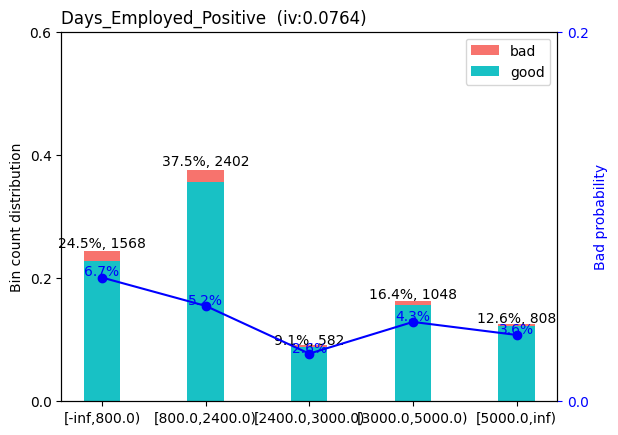

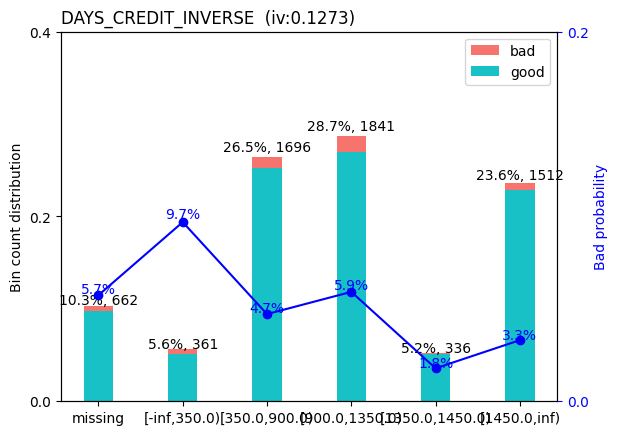

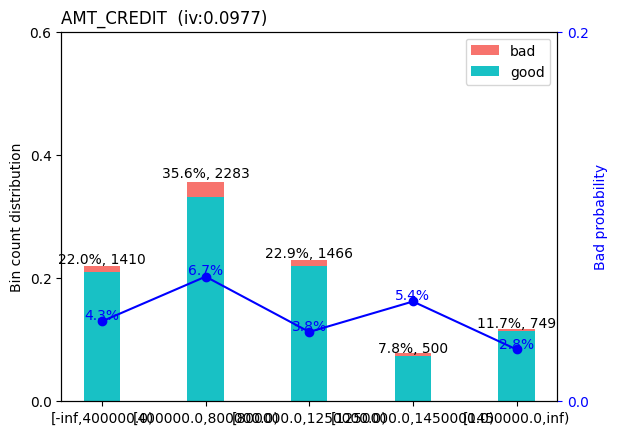

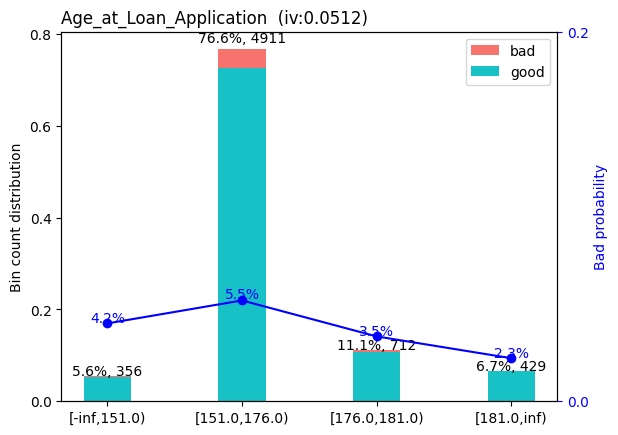

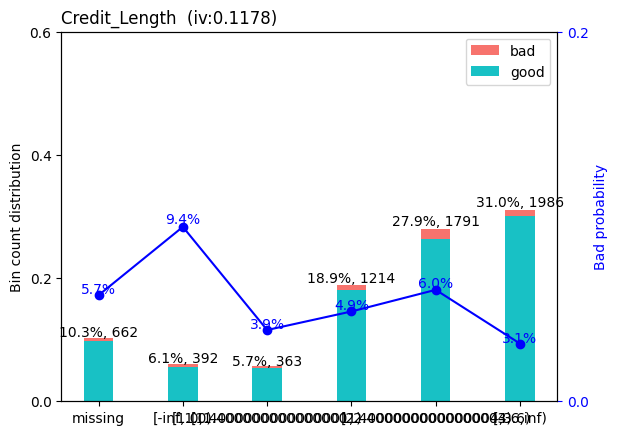

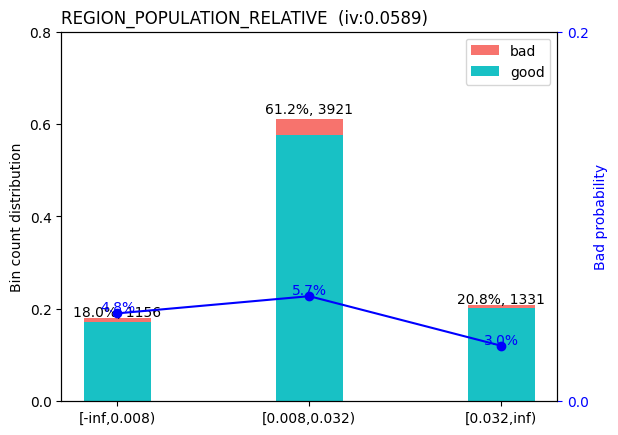

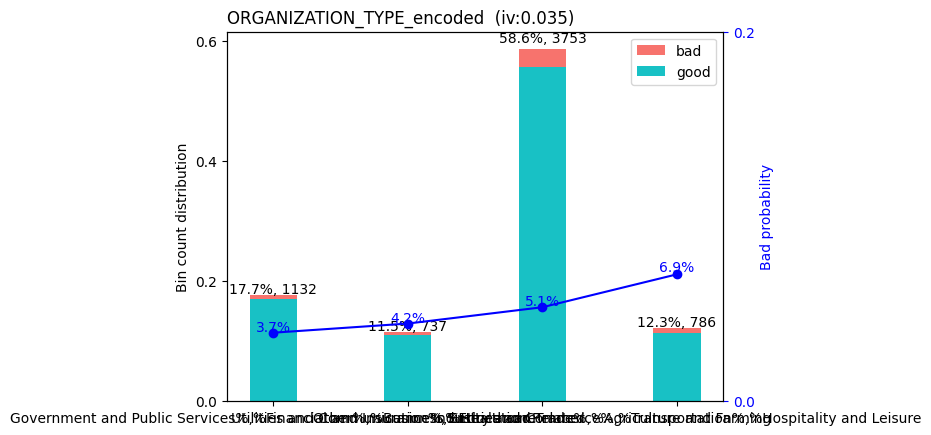

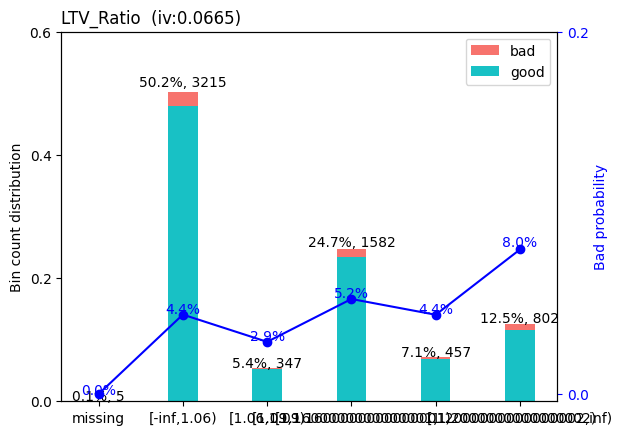

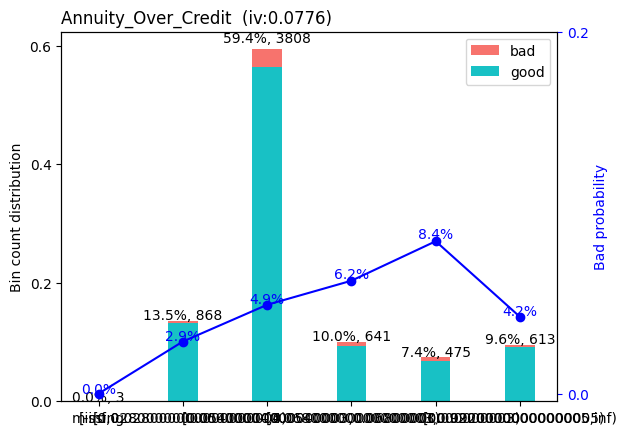

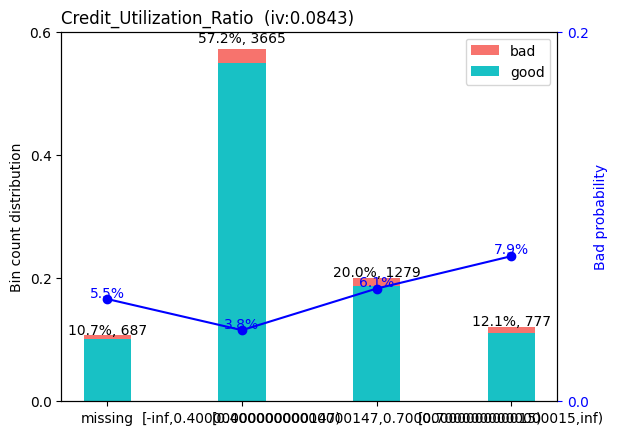

In [10]:
sc.woebin_plot(bins);

/usr/local/lib/python3.10/dist-packages/scorecardpy/condition_fun.py:40: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  datetime_cols = dat.apply(pd.to_numeric,errors='ignore').select_dtypes(object).apply(pd.to_datetime,errors='ignore').select_dtypes('datetime64').columns.tolist()


[INFO] creating woe binning ...


/usr/local/lib/python3.10/dist-packages/scorecardpy/woebin.py:320: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  init_bin = dtm.groupby('bin', group_keys=False)['y'].agg([n0, n1])\
/usr/local/lib/python3.10/dist-packages/scorecardpy/woebin.py:161: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  binning = dtm.groupby(['variable','bin'], group_keys=False)['y'].agg([n0, n1])\
/usr/local/lib/python3.10/dist-packages/scorecardpy/woebin.py:361: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. 

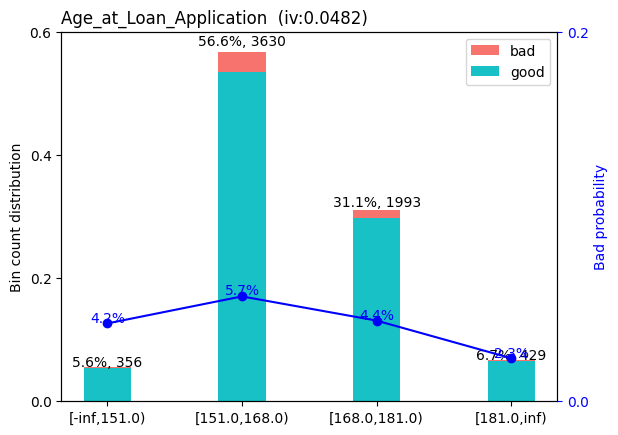

In [10]:
# breaks_adj = {'Annuity_Over_Credit':[0.028, 0.048, 0.064], 'Credit_Utilization_Ratio' : [ 0.475, 0.6, 0.7], 'Age_at_Loan_Application':[151, 168, 181], 'LTV_Ratio': [ 1.09, 1.12, 1.20], 'DAYS_CREDIT_INVERSE':[400, 1150, 1500], 'Credit_Length':[1.4, 2, 3, 4, 5]}
breaks_adj = {'Credit_Utilization_Ratio' : [ 0.475, 0.6, 0.7], 'Age_at_Loan_Application':[151, 168, 181], 'LTV_Ratio': [ 1.09, 1.12, 1.20], 'DAYS_CREDIT_INVERSE':[400, 1150, 1500], 'Credit_Length':[1.4, 2, 3, 4, 5]}
bins2 = sc.woebin(train, y = y, breaks_list = breaks_adj)
sc.woebin_plot(bins2['Age_at_Loan_Application']);

In [11]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    train_woe = sc.woebin_ply(train, bins2)
    test_woe = sc.woebin_ply(test, bins2)

[INFO] converting into woe values ...
[INFO] converting into woe values ...


In [12]:
with pd.option_context('display.max_rows', 6):
  display(train_woe)

,TARGET,AMT_CREDIT_woe,REGION_POPULATION_RELATIVE_woe,DAYS_CREDIT_INVERSE_woe,LTV_Ratio_woe,Credit_Length_woe,Days_Employed_Positive_woe,Age_at_Loan_Application_woe,Credit_Utilization_Ratio_woe,ORGANIZATION_TYPE_encoded_woe,Annuity_Over_Credit_woe
0,0,0.089093,-0.044289,-0.059381,0.027192,-0.023025,0.041580,-0.134502,-0.205035,-0.173276,-0.568565
1,0,0.325897,0.143976,-0.059381,-0.167955,-0.023025,0.041580,0.141663,-0.205035,0.026548,-0.167402
3,0,0.325897,0.143976,0.040404,0.027192,0.065071,-0.679957,-0.171480,-0.205035,-0.303911,-0.013871
...,...,...,...,...,...,...,...,...,...,...,...
8006,0,-0.292369,0.143976,-0.451941,0.027192,-0.448845,-0.338363,-0.782934,0.295595,0.026548,-0.013871
8007,0,-0.143893,-0.044289,-0.059381,-0.167955,-0.023025,0.041580,-0.134502,0.295595,0.026548,-0.013871
8008,0,0.325897,-0.521941,0.040404,-0.167955,0.088687,0.041580,-0.134502,0.130973,0.026548,0.563059


In [13]:
# sample code
# create the X, y parts of data for train and test
y_train = train_woe.loc[:, y]
X_train = train_woe.loc[:, train_woe.columns != y]
y_test = test_woe.loc[:, y]
X_test = test_woe.loc[:, train_woe.columns != y]

# create a logistic regression model object
lr = linear_model.LogisticRegression()
lr.fit(X_train, y_train)
# print(lr.coef_)
# print(lr.intercept_)
pd.Series(np.concatenate([lr.intercept_, lr.coef_[0]]),
          index = np.concatenate([['intercept'], lr.feature_names_in_]) )

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(

intercept                        -2.943035
AMT_CREDIT_woe                    0.786484
REGION_POPULATION_RELATIVE_woe    0.950771
DAYS_CREDIT_INVERSE_woe           0.638056
LTV_Ratio_woe                     0.834001
Credit_Length_woe                -0.070663
Days_Employed_Positive_woe        0.732033
Age_at_Loan_Application_woe       0.708060
Credit_Utilization_Ratio_woe      0.677746
ORGANIZATION_TYPE_encoded_woe     0.906087
Annuity_Over_Credit_woe           0.612497
dtype: float64

## Generate Scorecard

In [63]:
# generate a card from the model and bins. The scores will be based on probability of default from the model
card = sc.scorecard(bins2, lr, X_train.columns, points0 = 610, odds0 = 1/25, pdo = 15, basepoints_eq0 = True)
print(type(card)) # card is a dictionary
pprint.pprint(card)

<class 'dict'>
{'AMT_CREDIT':      variable                    bin  points
0  AMT_CREDIT        [-inf,400000.0)    63.0
1  AMT_CREDIT    [400000.0,800000.0)    55.0
2  AMT_CREDIT   [800000.0,1250000.0)    65.0
3  AMT_CREDIT  [1250000.0,1450000.0)    59.0
4  AMT_CREDIT        [1450000.0,inf)    71.0,
 'Age_at_Loan_Application':                    variable            bin  points
30  Age_at_Loan_Application   [-inf,151.0)    63.0
31  Age_at_Loan_Application  [151.0,168.0)    58.0
32  Age_at_Loan_Application  [168.0,181.0)    62.0
33  Age_at_Loan_Application    [181.0,inf)    72.0,
 'Annuity_Over_Credit':                variable                                         bin  points
43  Annuity_Over_Credit                                     missing    37.0
44  Annuity_Over_Credit                 [-inf,0.028000000000000004)    68.0
45  Annuity_Over_Credit  [0.028000000000000004,0.05400000000000003)    61.0
46  Annuity_Over_Credit   [0.05400000000000003,0.06800000000000003)    57.0
47  Annuity

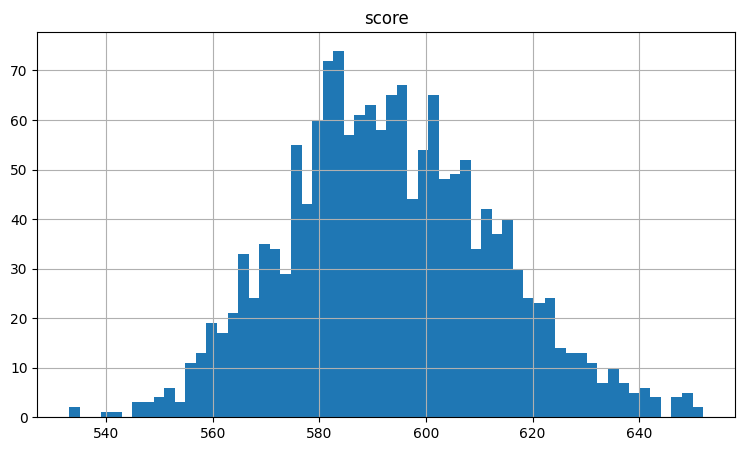

In [15]:
!pip install matplotlib
import matplotlib.pyplot as plt

# credit score for samples in test and train
train_score = sc.scorecard_ply(train, card)
test_score = sc.scorecard_ply(test, card)

# plot the distrubution of scores on test data
test_score.hist(figsize=(9, 5),bins = 60);

## Test

In [67]:
col = ["ORGANIZATION_TYPE_encoded", "DAYS_CREDIT_INVERSE", "REGION_POPULATION_RELATIVE", "Days_Employed_Positive", "LTV_Ratio", "Age_at_Loan_Application", "Credit_Length", "Annuity_Over_Credit", "Credit_Utilization_Ratio", "AMT_CREDIT"]
val = [['Other', 1123, 0.005, 1182, 1, 180, 3.572, 0.0753, 0.237, 820500]]
new_appl = pd.DataFrame(val, columns = col)

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    new_appl_score = sc.scorecard_ply(new_appl, card, only_total_score = False).transpose()
new_appl_score.index = new_appl_score.index.str.replace('_points', '')

summary = pd.concat([new_appl.transpose(), new_appl_score], axis=1)
summary.columns = ['App Value', 'Points']
print(summary)

                           App Value  Points
ORGANIZATION_TYPE_encoded      Other    60.0
DAYS_CREDIT_INVERSE             1123    60.0
REGION_POPULATION_RELATIVE     0.005    61.0
Days_Employed_Positive          1182    60.0
LTV_Ratio                          1    63.0
Age_at_Loan_Application          180    62.0
Credit_Length                  3.572    60.0
Annuity_Over_Credit           0.0753    53.0
Credit_Utilization_Ratio       0.237    63.0
AMT_CREDIT                    820500    65.0
score                            NaN   607.0


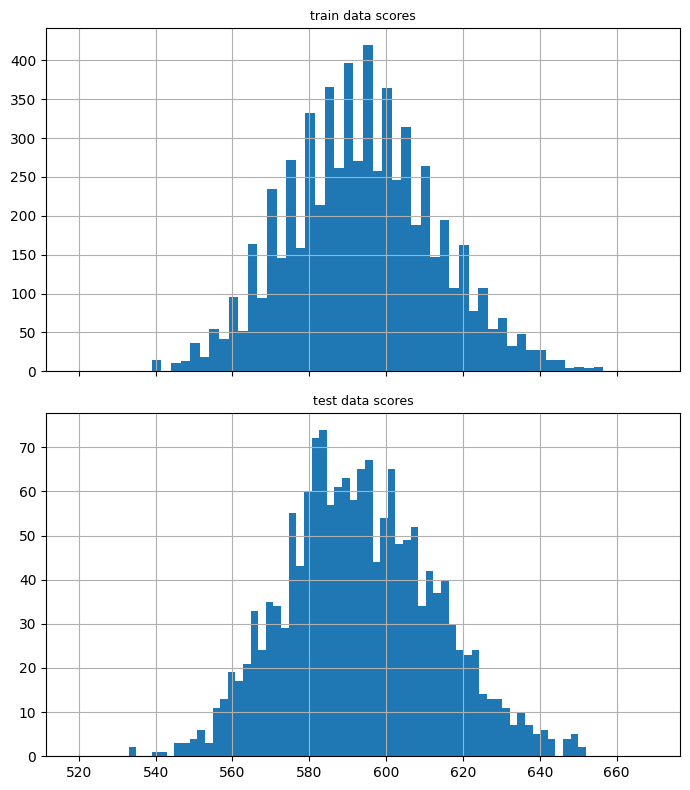

In [17]:
# credit score for samples in test and train
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    train_score = sc.scorecard_ply(train, card)
    test_score = sc.scorecard_ply(test, card)

# distribution of scores on train and test data
fig, ax = plt.subplots(2, 1, figsize = (7, 8), sharex = True)
train_score.hist(figsize = (7, 4), bins = 60, ax = ax[0])
ax[0].set_title('train data scores', fontsize = 9)
test_score.hist(figsize = (7, 4), bins = 60, ax = ax[1])
ax[1].set_title('test data scores', fontsize = 9)
plt.tight_layout()

In [18]:
# sample code
# print evaluation metrics of the model
y_pred = lr.predict(X_test)

print('Confusion matrix:')
print(metrics.confusion_matrix(y_test, y_pred))
print('PCC measures:')
print(metrics.classification_report(y_test, y_pred))

Confusion matrix:
[[1522    0]
 [  79    0]]
PCC measures:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      1522
           1       0.00      0.00      0.00        79

    accuracy                           0.95      1601
   macro avg       0.48      0.50      0.49      1601
weighted avg       0.90      0.95      0.93      1601



/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasatt

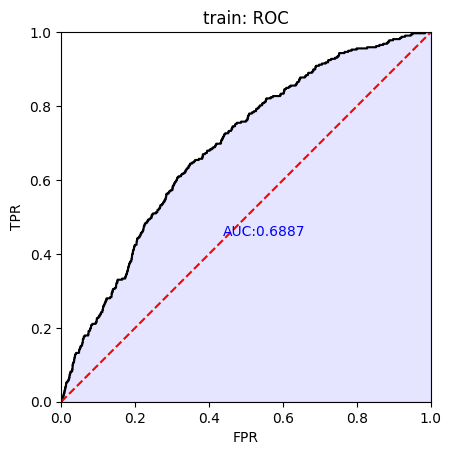

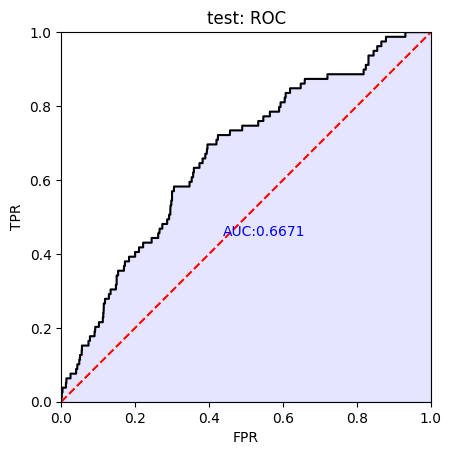

In [36]:
# sample code

# evaluate the performance of the logistic regression
train_pred = lr.predict_proba(X_train)[:, 1]
test_pred = lr.predict_proba(X_test)[:, 1]

# performance roc
train_perf = sc.perf_eva(y_train, train_pred, plot_type = ['roc'], title = 'train')
test_perf = sc.perf_eva(y_test, test_pred, plot_type = ['roc'], title = 'test')

In [ ]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1601 entries, 2 to 8000
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   REGION_POPULATION_RELATIVE  1601 non-null   float64
 1   Days_Employed_Positive      1601 non-null   int64  
 2   LTV_Ratio                   1601 non-null   float64
 3   Age_at_Loan_Application     1601 non-null   float64
 4   Credit_Length               1601 non-null   float64
 5   Annuity_Over_Credit         1601 non-null   float64
 6   Credit_Utilization_Ratio    1601 non-null   float64
 7   AMT_CREDIT                  1601 non-null   float64
 8   DAYS_CREDIT_INVERSE         1601 non-null   float64
 9   ORGANIZATION_TYPE_encoded   1601 non-null   object 
dtypes: float64(8), int64(1), object(1)
memory usage: 137.6+ KB


## Decision Tree

In [ ]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score
import pandas as pd


# Extract features and target variable for training and testing
X_train = train.drop(columns=[y])  # Extract features (drop the target variable)
y_train = train[y]  # Extract target variable

X_test = test.drop(columns=[y])  # Extract features (drop the target variable)
y_test = test[y]  # Extract target variable

# Fill NaN values with 0
X_train = X_train.fillna(0)
X_test = X_test.fillna(0)

# Identify the column containing categorical feature
categorical_columns = ['ORGANIZATION_TYPE']  # Assuming 'ORGANIZATION_TYPE' is the categorical column

# Create a pipeline for preprocessing and modeling
preprocessor = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(), categorical_columns)
    ],
    remainder='passthrough'
)

# Combine preprocessing and modeling steps into a single pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(max_depth=5, min_samples_split=5, random_state=2))
])

# Fit the pipeline on the training data
pipeline.fit(X_train, y_train)

# Make predictions on test data
test_pred_dt = pipeline.predict_proba(X_test)[:, 1]

# Evaluate performance using ROC curve
test_perf_dt = roc_auc_score(y_test, test_pred_dt)
print("Test ROC AUC Score:", test_perf_dt)


ValueError: A given column is not a column of the dataframe

In [ ]:
train_woe['TARGET'].unique()

array([0, 1])

Epoch 1/10
71/71 [==============================] - 3s 13ms/step - loss: 0.2613 - accuracy: 0.9465 - val_loss: 0.1720 - val_accuracy: 0.9599
Epoch 2/10
71/71 [==============================] - 1s 9ms/step - loss: 0.1964 - accuracy: 0.9480 - val_loss: 0.1685 - val_accuracy: 0.9599
Epoch 3/10
71/71 [==============================] - 1s 12ms/step - loss: 0.1951 - accuracy: 0.9480 - val_loss: 0.1686 - val_accuracy: 0.9599
Epoch 4/10
71/71 [==============================] - 1s 14ms/step - loss: 0.1943 - accuracy: 0.9480 - val_loss: 0.1664 - val_accuracy: 0.9599
Epoch 5/10
71/71 [==============================] - 1s 14ms/step - loss: 0.1931 - accuracy: 0.9480 - val_loss: 0.1687 - val_accuracy: 0.9599
Epoch 6/10
71/71 [==============================] - 1s 11ms/step - loss: 0.1928 - accuracy: 0.9480 - val_loss: 0.1738 - val_accuracy: 0.9599
Epoch 7/10
71/71 [==============================] - 1s 8ms/step - loss: 0.1929 - accuracy: 0.9480 - val_loss: 0.1703 - val_accuracy: 0.9599
Epoch 8/10
71/7

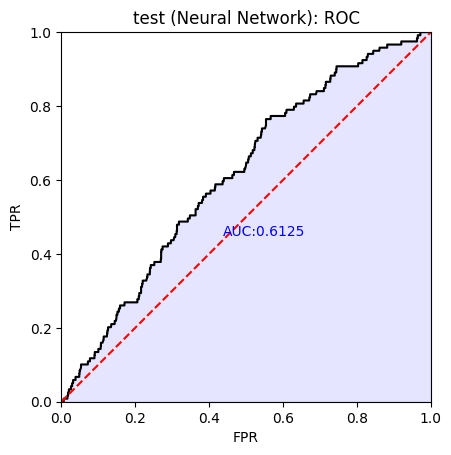

In [ ]:
import tensorflow as tf

# Define the neural network architecture
model = tf.keras.Sequential([
    tf.keras.layers.Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2)

# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(X_test, y_test)

# Make predictions on test data
test_pred_nn = model.predict(X_test)

# Flatten the predictions array
test_pred_nn_flat = np.squeeze(test_pred_nn)

# Evaluate performance using ROC curve
test_perf_nn = sc.perf_eva(y_test, test_pred_nn_flat, plot_type=['roc'], title='test (Neural Network)')
